In [114]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
from Common import NeuralNet, MultiVariatePoly
import time
torch.autograd.set_detect_anomaly(True)
torch.manual_seed(128)
# torch.manual_seed
import pandas as pd

import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.preprocessing import MinMaxScaler

### FNO

The Temperature evolution of the solid and fluid phases $T_S$ and $T_f$ is described by a sdystem of two linear reaction-convection diffusion equation $$\begin{aligned} \varepsilon \rho_{f} C_{f} \frac{\partial T_{f}}{\partial t}+\varepsilon \rho_{f} C_{f} u_{f}(t) \frac{\partial T_{f}}{\partial x}=\lambda_{f} \frac{\partial^{2} T_{f}}{\partial x^{2}}-h_{v}\left(T_{f}-T_{s}\right) & x \in[0, L], t \in[0, T] \\ (1-\varepsilon) \rho_{s} C_{s} \frac{\partial T_{s}}{\partial t}=\lambda_{s} \frac{\partial^{2} T_{s}}{\partial x^{2}}+h_{v}\left(T_{f}-T_{s}\right) & x \in[0, L], t \in[0, T]\end{aligned}$$


### Learning Operators

Mapping between two infinite dimensional spaces from a finite collection of observed input-output pairs (i.e $(t, T_s)$ and $(t, T_f)$)

We want to find a solution operator (map) $G^\dagger$ of the parametric PDE above by constructing a parametric map $$ G_\theta: \mathcal{A} \rightarrow \mathcal{U}$$ for some parameter $\theta^\dagger \in \Theta$ (where $\Theta$ is some finite dimensional parameter space), such that this approximation map $$G(\cdot, \theta^\dagger) = G_{\theta^\dagger} \simeq G^\dagger$$

Approximating this solution operator $G^\dagger$ is different than finding the solution $u \in \mathcal{U}$ of a PDE for a single instance of the parameter $a \in \mathcal{A}$

## Operator Learning

- The spatial domain for the PDE $D \subset \mathbb{R}^d$ (in our case simply $t \in \mathbb{R}$, where $t$ correspond to the points in the spatial domain)
- $a \in \mathcal{A} = (D; \mathbb{R}^{d_a})$ are the **input coefficient functions**
- $u \in \mathcal{U} = (D; \mathbb{R}^{d_u})$ are the **target solution functions**

Given a set of observations s $\{a_j, u_j\}_{j =1}^N$, the function $D_j$ describes the discretization of $(a_j, u_j)$

## Import Data

In [115]:
train_data = pd.read_csv("Task3/TrainingData.txt")
test_data = pd.read_csv("Task3/TestingData.txt")

Tf = torch.from_numpy(train_data['tf0'].to_numpy()).type(torch.float32)
Ts = torch.from_numpy(train_data['ts0'].to_numpy()).type(torch.float32)

t_train = train_data['t'].to_numpy()
t_pred = test_data['t'].to_numpy()
t_pred = np.append(t_pred, t_pred[-1]+(t_pred[1] - t_pred[0]))
t_total = np.append(t_train, t_pred)

### Normalize Data

In [116]:
scaler_t = MinMaxScaler()
scaler_Tf = MinMaxScaler()
scaler_Ts = MinMaxScaler()

n_train = 210
batch_dim = 35
batch_size = 2

t_total_norm = torch.tensor(scaler_t.fit_transform(t_total.reshape(-1,1)), dtype=torch.float)
print(t_total_norm.shape)

Tf_norm = torch.tensor(scaler_Tf.fit_transform(train_data['tf0'].to_numpy().reshape(-1, 1)), dtype=torch.float)
Ts_norm = torch.tensor(scaler_Ts.fit_transform(train_data['ts0'].to_numpy().reshape(-1, 1)), dtype=torch.float )


input_Tf = torch.stack([Tf_norm.reshape(-1), t_total_norm[:-35].reshape(-1)], dim=1).reshape(-1, batch_dim, 2)
input_Ts = torch.stack([Ts_norm.reshape(-1), t_total_norm[:-35].reshape(-1)], dim=1).reshape(-1, batch_dim, 2)

input_Tf_train = input_Tf[:-1, :]
input_Ts_train = input_Ts[:-1, :]

print("Input Ts train shape: {}".format(input_Ts_train.shape))
print("Input Tf train shape: {}".format(input_Tf_train.shape))

output_Tf_train = input_Tf[1:, :, 0]
output_Ts_train = input_Ts[1:, :, 0]

print("Output Ts train shape: {}".format(output_Tf_train.shape))
print("Output Tf train shape: {}".format(output_Ts_train.shape))


torch.Size([245, 1])
Input Ts train shape: torch.Size([5, 35, 2])
Input Tf train shape: torch.Size([5, 35, 2])
Output Ts train shape: torch.Size([5, 35])
Output Tf train shape: torch.Size([5, 35])


#### Plot Unnormalized and Normalized Data

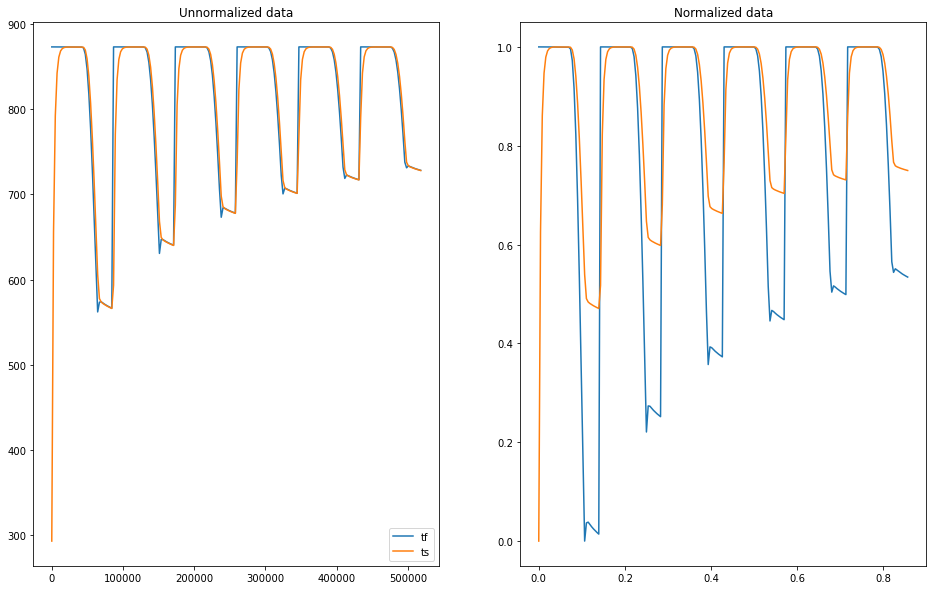

In [117]:
fig, ax = plt.subplots(1,2, figsize = (16, 10))

ax[0].plot(t_total[:-35], Tf, label = "tf")
ax[0].plot(t_total[:-35], Ts, label = 'ts')
ax[0].legend()
ax[0].set_title("Unnormalized data")

ax[1].plot(t_total_norm[:-35], Tf_norm, label = 'tf_norm')
ax[1].plot(t_total_norm[:-35], Ts_norm, label = 'ts_norm')
ax[1].set_title("Normalized data")

plt.show()

In [118]:
training_set_Tf = DataLoader(TensorDataset(input_Tf_train, output_Tf_train), batch_size=batch_size, shuffle=True)
training_set_Ts = DataLoader(TensorDataset(input_Ts_train, output_Ts_train), batch_size=batch_size, shuffle=True)

## 1D FNO Model

In [119]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')


################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

In [120]:
learning_rate = 0.001

epochs = 1000
step_size = 50
gamma = 0.5

modes = 17
width = 64

fno_Tf = FNO1d(modes, width)
fno_Ts = FNO1d(modes, width) 

#### Optimizer $T_f$

In [121]:
optimizer = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        optimizer.zero_grad()
        output_pred_batch = fno_Tf(input_batch).squeeze(2) # gives you the prediction of T_s or T_f
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Tf)

    scheduler.step()

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse)


######### Epoch: 0  ######### Train Loss: 0.42211022476355237
######### Epoch: 10  ######### Train Loss: 0.00444032670930028
######### Epoch: 20  ######### Train Loss: 0.00046301875651503604
######### Epoch: 30  ######### Train Loss: 0.0002692613973825549
######### Epoch: 40  ######### Train Loss: 0.00017449541701353155
######### Epoch: 50  ######### Train Loss: 0.00011676115658095416
######### Epoch: 60  ######### Train Loss: 9.470642483696186e-05
######### Epoch: 70  ######### Train Loss: 7.307192511992373e-05
######### Epoch: 80  ######### Train Loss: 0.00010769946948130382
######### Epoch: 90  ######### Train Loss: 4.5563362315685176e-05
######### Epoch: 100  ######### Train Loss: 4.3664564752058745e-05
######### Epoch: 110  ######### Train Loss: 3.2850576038375344e-05
######### Epoch: 120  ######### Train Loss: 3.195194009701178e-05
######### Epoch: 130  ######### Train Loss: 2.9258096825894125e-05
######### Epoch: 140  ######### Train Loss: 3.0854835434486937e-05
######### Epoch:

#### Optimizer for $T_s$

In [122]:
optimizer = Adam(fno_Ts.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Ts):
        optimizer.zero_grad()
        output_pred_batch = fno_Ts(input_batch).squeeze(2) # gives you the prediction of T_s or T_f
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Ts)

    scheduler.step()

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse)

######### Epoch: 0  ######### Train Loss: 0.9974132974942526
######### Epoch: 10  ######### Train Loss: 0.014245791671176752
######### Epoch: 20  ######### Train Loss: 0.0005030301496541748
######### Epoch: 30  ######### Train Loss: 0.0001456024013653708
######### Epoch: 40  ######### Train Loss: 0.00011694694452065353
######### Epoch: 50  ######### Train Loss: 8.794253638673884e-05
######### Epoch: 60  ######### Train Loss: 7.388626121003956e-05
######### Epoch: 70  ######### Train Loss: 6.623898904460172e-05
######### Epoch: 80  ######### Train Loss: 6.948874700659265e-05
######### Epoch: 90  ######### Train Loss: 5.9985336217020326e-05
######### Epoch: 100  ######### Train Loss: 5.43479703386159e-05
######### Epoch: 110  ######### Train Loss: 5.4508564062416553e-05
######### Epoch: 120  ######### Train Loss: 4.939136670145672e-05
######### Epoch: 130  ######### Train Loss: 3.857717183564091e-05
######### Epoch: 140  ######### Train Loss: 3.75014794068799e-05
######### Epoch: 150  ##

### Plot the Training Results

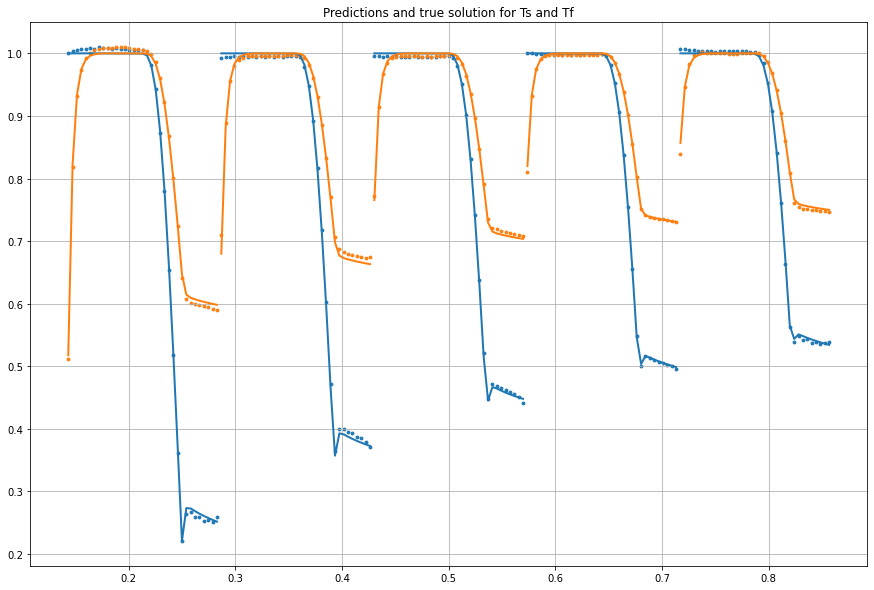

In [123]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
ax.grid()
ax.set_title("Predictions and true solution for Ts and Tf")

# fig.figure(dpi=250)
# fig.grid(True, which="both", ls=":")

# Plot fno_Tf & fno_Ts
assert input_Tf.shape[0] == input_Ts.shape[0]

for i in range(input_Tf_train.shape[0]):

    input_function_test_Tf = input_Tf_train[i, :].unsqueeze(0)
    output_function_test_Tf = output_Tf_train[i, :].unsqueeze(0)

    input_function_test_Ts = input_Ts_train[i, :].unsqueeze(0)
    output_function_test_Ts = output_Ts_train[i, :].unsqueeze(0)

    output_function_test_pred_Tf = fno_Tf(input_function_test_Tf)
    output_function_test_pred_Ts = fno_Ts(input_function_test_Ts)
    
    ax.plot(input_Tf[i+1, :][:, 1].detach(), output_function_test_Tf[0].detach(), label="True Solution", c="C0", lw=2)
    ax.scatter(input_Tf[i+1, :][:, 1].detach(), output_function_test_pred_Tf[0].detach(), label="Approximate Solution", s=8, c="C0")

    ax.plot(input_Ts[i+1, :][:, 1].detach(), output_function_test_Ts[0].detach(), label="True Solution", c="C1", lw=2)
    ax.scatter(input_Ts[i+1, :][:, 1].detach(), output_function_test_pred_Ts[0].detach(), label="Approximate Solution", s=8, c="C1")
    # print()
# ax.legend()
plt.show()

### Get the predictions for the test data (from 0.83 - 1.0)

torch.Size([175])


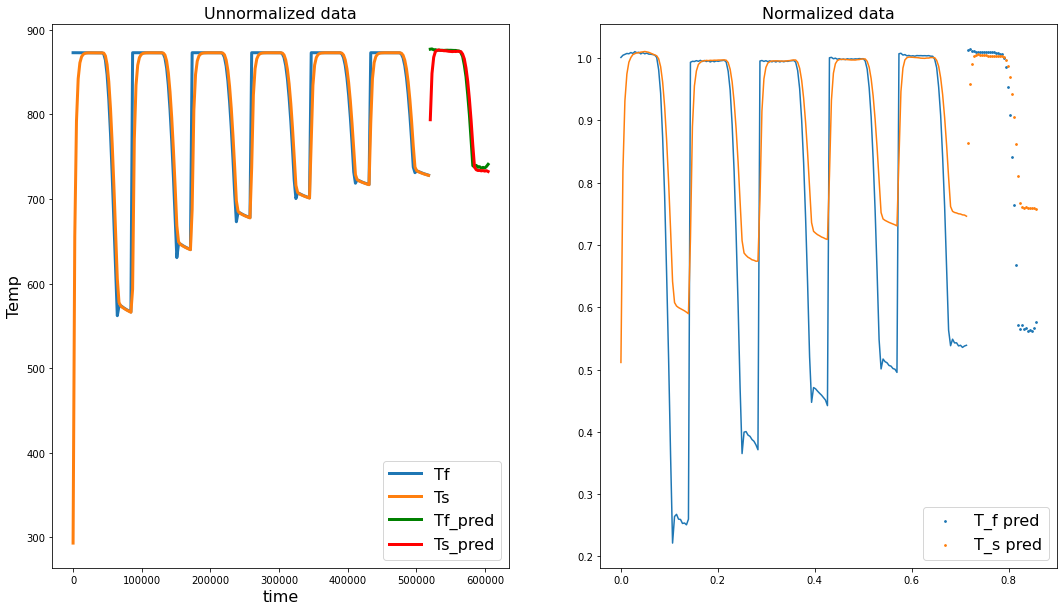

In [126]:
fontsize = 16
markersize = 3

input_Tf_pred = input_Tf[-1, :].unsqueeze(0)
input_Ts_pred = input_Ts[-1, :].unsqueeze(0)

'''
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Get predictions of test set on normalized input data
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
'''
output_pred_Tf = fno_Tf(input_Tf_pred).squeeze()
output_pred_Ts = fno_Ts(input_Ts_pred).squeeze()
'''
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Invert data to get unnormalized results
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
'''
# Prediction on the test data in the original scale
output_pred_Tf_org = scaler_Tf.inverse_transform(output_pred_Tf.detach().reshape(-1, 1))
output_pred_Ts_org = scaler_Ts.inverse_transform(output_pred_Ts.detach().reshape(-1, 1))


output_pred_Tf_train = fno_Tf(input_Tf_train)
output_pred_Ts_train = fno_Ts(input_Ts_train)

fig, ax = plt.subplots(1,2, figsize = (18,10))

ax[0].plot(t_total[:-35], Tf, label='Tf', linewidth=3)
ax[0].plot(t_total[:-35], Ts, label='Ts', linewidth=3)

ax[0].plot(t_total[-35:], output_pred_Tf_org, label='Tf_pred', c="green", linewidth=3)
ax[0].plot(t_total[-35:], output_pred_Ts_org, label='Ts_pred', c="red", linewidth=3)

ax[0].set_xlabel('time', size=fontsize)
ax[0].set_ylabel('Temp', size=fontsize)
ax[0].legend(fontsize=fontsize)
ax[0].set_title('Unnormalized data', size=fontsize)


ax[1].set_title("Normalized data", size = fontsize)

# print(input_Tf_train[0,:,1].shape)
print(output_pred_Tf_train.view(len(t_train[:-35])).shape)
ax[1].plot(input_Tf_train.reshape(-1,2)[:,1], output_pred_Tf_train.view(len(t_train[:-35])).detach())
ax[1].plot(input_Tf_train.reshape(-1,2)[:,1], output_pred_Ts_train.view(len(t_train[:-35])).detach())

ax[1].scatter(input_Tf_pred[0,:, 1], output_pred_Tf.detach(), label = "T_f pred", s = markersize)
ax[1].scatter(input_Ts_pred[0,:, 1], output_pred_Ts.detach(), label = 'T_s pred', s = markersize)

ax[1].legend(fontsize=fontsize)

plt.show()

### Compare predictions of training to correct results

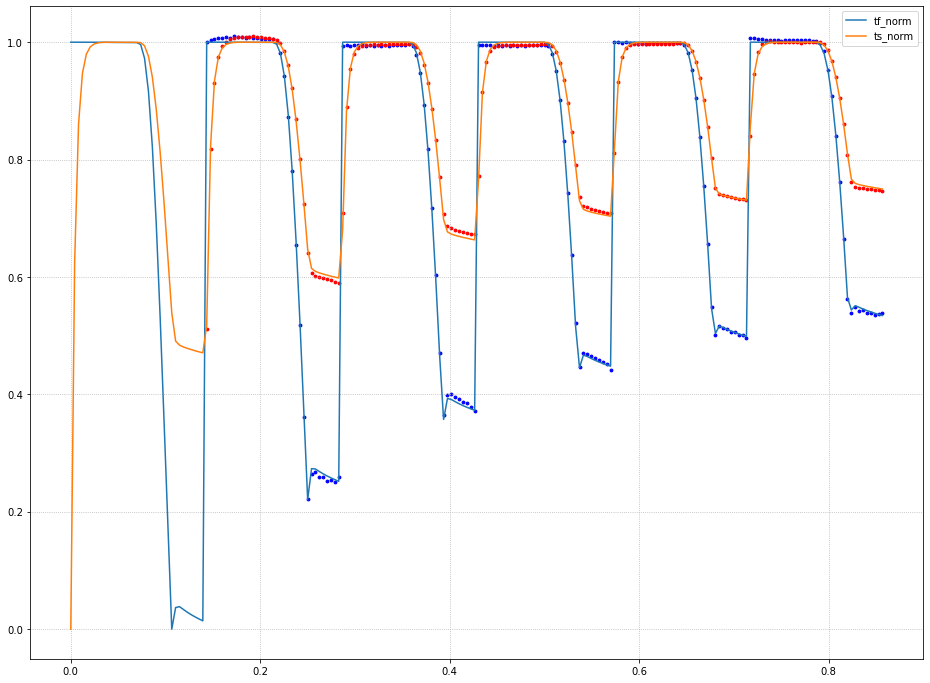

<Figure size 1500x1000 with 0 Axes>

In [127]:
fig, ax = plt.subplots(1,1, figsize = (16, 12))
plt.grid(True, which="both", ls=":")
com_div = 35
plt.figure(dpi=250)

batch_size = 35
for i in range(input_Tf_train.shape[0]):
    input_function_n_tf = input_Tf_train[i, :].unsqueeze(0)
    output_pred_tf_n = fno_Tf(input_function_n_tf)
    ax.scatter(input_Tf.reshape(-1,2)[(i+1)*batch_size:(i+1)*batch_size+batch_size, 1].detach(), output_pred_tf_n[0].detach(), s=8, c="blue")

for i in range(input_Ts_train.shape[0]):
    input_function_n_ts = input_Ts_train[i, :].unsqueeze(0)
    output_pred_ts_n = fno_Ts(input_function_n_ts)
    ax.scatter(input_Ts.reshape(-1,2)[(i+1)*batch_size:(i+1)*batch_size+batch_size, 1].detach(), output_pred_ts_n[0].detach(), s=8, c="red")

ax.plot(t_total_norm[:-35], Tf_norm, label = 'tf_norm')
ax.plot(t_total_norm[:-35], Ts_norm, label = 'ts_norm') 
# ax.plot(t_train_norm, Ts0_norm, label = 'ts_norm')
# ax.set_title("Normalized data")
ax.legend()

plt.show()

### Save the predictions

In [128]:
save_path_pred = "Fabian_Jaeger_17-740-325"

pred_Tf_save = output_pred_Tf_org[:-1].reshape(-1)
pred_Ts_save = output_pred_Ts_org[:-1].reshape(-1)
t_save = t_total[210:-1]
    
try:
    os.makedirs(save_path_pred)
except:
    print("Path already exists")

df_save = pd.DataFrame({'t': t_save, 'tf0': pred_Tf_save, 'ts0': pred_Ts_save})
df_save.to_csv('{}/pred3.txt'.format(save_path_pred), index=False)


Path already exists
